# RL Assignment - Deep Q Network 

## Imports

In [1]:
import math
import os
import random

import gym
import matplotlib.pyplot as plt
import minihack
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from gym import spaces
from nle import nethack
from PIL import Image
from torch import flatten
from torch.nn import (BatchNorm2d, Conv2d, CrossEntropyLoss, Dropout, Linear,
                      MaxPool2d, Module, ReLU, Sequential, Softmax)

Set device to use GPU if available

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Helper Functions

Converts state into form that the neural network can read

In [3]:
def format_state(state):
    glyphs = state["glyphs"]
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    return torch.from_numpy(glyphs).squeeze(0)

Plots the reward attained by an Agent at each step of training in an environment for each iteration and average over all iterations

In [4]:
def plot_results(env_name, scores, color, ylim):
  
    plt.figure(figsize=(8,6))
    
    # Plot individual iterations 
    for score in scores:
        plt.plot(score, alpha = 0.1, color=color)
    
    # Plot mean over all iterations
    mean = np.mean(scores,axis=0)
    plt.plot(mean, color=color,label="Average Reward")
    
    plt.title(f"DQN - {env_name}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.yticks(np.arange(ylim[0], ylim[1], 1.00))
    plt.legend(loc=4)
    plt.savefig(f"DQN - {env_name}.png")
    plt.show()

## DQN Model

In [5]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

In [6]:
class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network.
    """

    def __init__(self, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param action_space: the action space of the environment
        """
        super().__init__()
        
        self.conv_layer1 = Conv2d(in_channels=1, out_channels=20, kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.conv_layer2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fully_conn_layer1 = Linear(in_features=1600, out_features=500)
        self.relu3 = ReLU()
        
        self.fully_conn_layer2 = Linear(in_features=500, out_features=action_space.n)

    def forward(self, x):
        """
        Returns the values of a forward pass of the network
        :param x: The input to feed into the network 
        """
        # define first conv layer with max pooling
        x = self.conv_layer1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # define second conv layer with max pooling
        x = self.conv_layer2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # Define fully connected layers
        x = x.reshape(x.shape[0], -1)
        x = self.fully_conn_layer1(x)
        x = self.relu3(x)
        x = self.fully_conn_layer2(x)
        return x

In [7]:
# Define class that brings all the DQN compenents together so that a model can be trained
class DQNAgent():
    def __init__(self, observation_space, action_space, **kwargs):
        global device
        self.action_space = action_space
        self.replay_buffer = kwargs.get("replay_buffer", None)
        self.use_double_dqn = kwargs.get("use_double_dqn", None)
        self.gamma = kwargs.get("gamma", 0.99)
        self.lr = kwargs.get("lr", None)
        self.betas = kwargs.get("betas", (0.9, 0.999))
        self.batch_size = kwargs.get("batch_size", None)
        # Create the online and target network
        self.online_network = DQN(action_space).to(device)
        self.target_network = DQN(action_space).to(device)
        self.optimiser = torch.optim.Adam(self.online_network.parameters(), lr=self.lr, betas=self.betas)
   

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        with torch.no_grad():
            if self.use_double_dqn:
                _, max_next_action = self.online_network(next_states).max(1)
                max_next_q_values = self.target_network(next_states).gather(1, max_next_action.unsqueeze(1)).squeeze()
            else:
                next_q_values = self.online_network(next_states)
                max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        input_q_values = self.target_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        del states
        del next_states
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.online_network.state_dict())

    def act(self, observation):
        """Select action base on network inference"""
        if not torch.cuda.is_available():
            observation = observation.type(torch.FloatTensor) 
        else:
            observation = observation.type(torch.cuda.FloatTensor) 
        state = torch.unsqueeze(observation, 0).to(device)
        result = self.online_network.forward(state)
        action = torch.argmax(result).item()
        return action


## DQN Method

In [8]:
def dqn(env, seed, learning_rate, max_episodes, max_episode_length, gamma, verbose=True):
    """
    Method to train DQN model.
    
    Input:
    env: The environment to be used during training
    seed: The random seed for any random operations performed 
    learning_rate: The learning rate uesd for the Adam optimizer when training the model 
    number_episodes: Number of episodes to train for 
    max_episode_length: The maximum number of steps to take in an episode before terminating
    gamma: The discount factor used when calculating the discounted rewards of an episode
    
    Returns:
    scores: The cumulative reward achieved by the agent for each episode during traiing
    """

    hyper_params = {
        'replay-buffer-size': int(1e6),
        'learning-rate': 0.01,
        'gamma': 0.99,  # discount factor
        'num-steps': int(2e5),  # Steps to run for, max episodes should be hit before this
        'batch-size': 32,  
        'learning-starts': 1000,  # set learning to start after 1000 steps of exploration
        'learning-freq': 1,  # Optimize after each step
        'use-double-dqn': True,
        'target-update-freq': 1000, # number of iterations between every target network update
        'eps-start': 1.0,  # e-greedy start threshold 
        'eps-end': 0.1,  # e-greedy end threshold 
        'eps-fraction': 0.4,  # Percentage of the time that epsilon is annealed
        'print-freq': 10,

    }
    
    np.random.seed(seed)
    env.seed(seed)
    
    # Create DQN agent
    replay_buffer = ReplayBuffer(hyper_params['replay-buffer-size'])
    agent = DQNAgent(
        env.observation_space, 
        env.action_space,
        train=True,
        replay_buffer=replay_buffer,
        use_double_dqn=hyper_params['use-double-dqn'],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['gamma'],
    )
    
    # define variables to track agent metrics
    total_reward = 0
    scores = []
    mean_rewards = []

    # Reset gym env before training
    state = format_state(env.reset())
    eps_timesteps = hyper_params['eps-fraction'] * float(hyper_params['num-steps'])
    # Train for set number of steps
    for t in range(hyper_params['num-steps']):
        # determine exploration probability
        fract = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fract * (hyper_params["eps-end"] - hyper_params["eps-start"])
        sample = random.random()
        # Decide to explore and choose random action or use model to act
        if sample < eps_threshold:
            action = np.random.choice(agent.action_space.n)
        else:
            action = agent.act(state)
        # Take step in environment
        (next_state, reward, done, _) = env.step(action)
        next_state = format_state(next_state)
        replay_buffer.add(state, action, reward, next_state, float(done))
        total_reward += reward
        state = next_state
        if done:
            scores.append(total_reward)
            print(f"episode reward: {total_reward}")
            np.random.seed(seed)
            env.seed(seed)
            state = format_state(env.reset())
            total_reward = 0

        if t > hyper_params['learning-starts'] and t % hyper_params['learning-freq'] == 0:
            ans = agent.optimise_td_loss()

        if t > hyper_params['learning-starts'] and t % hyper_params['target-update-freq'] == 0:
            agent.update_target_network()

        num_episodes = len(scores)
        if done and hyper_params['print-freq'] is not None and len(scores) % hyper_params['print-freq'] == 0:
            mean_100ep_reward = round(np.mean(scores[-101:-1]), 1)
            mean_rewards.append(mean_100ep_reward)
            
        if num_episodes >=max_episodes:
            return scores

    return scores

In [9]:
def run_dqn(env,number_episodes,max_episode_length,iterations):
    """Trains DQN model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for seed in seeds:
        print(seed)
        # Train the DQN Model 
        scores = dqn(env=env, 
                            seed=seed, 
                            learning_rate=0.01,
                            max_episodes=number_episodes, 
                            max_episode_length=max_episode_length, 
                            gamma=0.99 ,
                            verbose=True)
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

## Room 5x5 
Training model on Room 5x5 environment

In [10]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
env = gym.make("MiniHack-Room-5x5-v0", observation_keys=["glyphs","pixel","message"], actions=MOVE_ACTIONS)

# Train DQN on room 5x5
room_5x5_scores = run_dqn(env,number_episodes=100,max_episode_length=200,iterations=5)

/usr/local/lib/python3.9/dist-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments
/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (21, 79)
  logger.warn(


791


/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(
/home/sweets/.local/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95


/home/sweets/.local/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: -0.20000000000000004
episode reward: 0.95
episode reward: 0.94
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.94
episode reward: 0.95
episode reward: 0.95
episode reward: -0.20000000000000004
episode reward: 0.95
episode reward: 0.95
episode reward: 0.94
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: 0.95
episode reward: -0.2800000000000001
episode reward: 0.97
episode reward: 0.9299999999999999
episode reward: -0.25000000000000006
episode reward: -0.3200000000000001
episode reward: -0.4100000000000002
episode reward: 0.92999999999999

episode reward: 0.7899999999999999
episode reward: -0.24000000000000007
episode reward: -0.23000000000000007
230
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.88
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.9
episode reward: 0.88
episode reward: 0.9
episode reward: 0.9
episo

Plot results

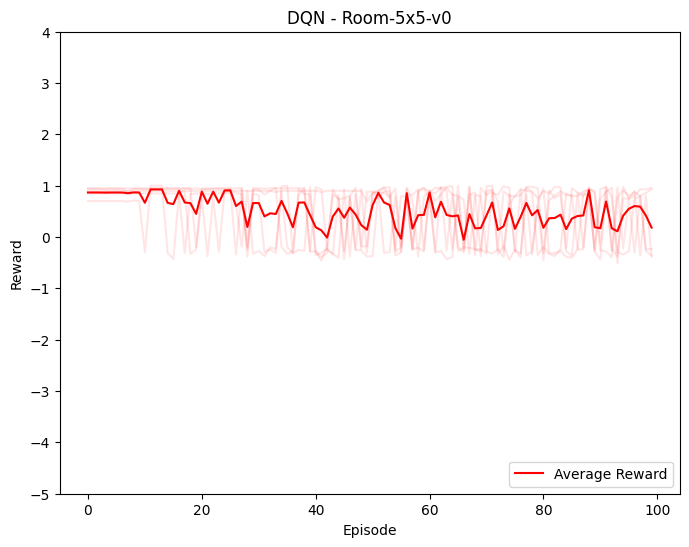

In [11]:
plot_results(env_name="Room-5x5-v0", scores=room_5x5_scores, ylim = (-5,5),color = "red")

## Eat

In [12]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
MOVE_ACTIONS += (nethack.Command.EAT,)
env = gym.make("MiniHack-Eat-v0", observation_keys=["glyphs","pixel","message"], actions=MOVE_ACTIONS)

# Train DQN on eat
eat_scores = run_dqn(env,number_episodes=150,max_episode_length=200,iterations=5)

/usr/local/lib/python3.9/dist-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


609
episode reward: -0.7700000000000005
episode reward: -0.7600000000000005
episode reward: -0.7500000000000004
episode reward: -0.7600000000000005
episode reward: -0.9200000000000006
episode reward: -0.9200000000000006
episode reward: -0.9700000000000006
episode reward: -0.9100000000000006
episode reward: -0.6900000000000004
episode reward: -1.0000000000000007
episode reward: 0.14999999999999947
episode reward: -0.8300000000000005
episode reward: -0.8600000000000005
episode reward: -1.0000000000000007
episode reward: 0.1799999999999995
episode reward: -0.9000000000000006
episode reward: 0.5099999999999998
episode reward: -0.8600000000000005
episode reward: -0.9400000000000006
episode reward: 0.3899999999999997
episode reward: -0.9100000000000006
episode reward: -0.8200000000000005
episode reward: 0.5499999999999998
episode reward: 0.5699999999999998
episode reward: -0.8100000000000005
episode reward: 0.5799999999999998
episode reward: 0.5699999999999998
episode reward: 0.3499999999999

episode reward: 0.8099999999999999
episode reward: -1.290000000000001
episode reward: -0.8300000000000005
episode reward: -1.0200000000000007
episode reward: -1.1900000000000008
episode reward: -1.1800000000000008
episode reward: -1.260000000000001
episode reward: -1.1900000000000008
episode reward: -1.0400000000000007
episode reward: -1.0500000000000007
episode reward: -1.1400000000000008
episode reward: -1.1200000000000008
episode reward: -1.260000000000001
episode reward: -1.0000000000000007
episode reward: -1.0200000000000007
episode reward: -1.2200000000000009
episode reward: -1.1500000000000008
episode reward: -1.1000000000000008
episode reward: -1.2300000000000009
episode reward: -1.2400000000000009
episode reward: -1.270000000000001
episode reward: -1.1200000000000008
episode reward: -1.1800000000000008
episode reward: -1.1500000000000008
episode reward: -1.0200000000000007
episode reward: -1.1900000000000008
episode reward: -1.1300000000000008
episode reward: -0.90000000000000

episode reward: -0.9400000000000006
episode reward: -1.0500000000000007
episode reward: -1.0400000000000007
episode reward: -0.8400000000000005
episode reward: -0.8500000000000005
episode reward: -1.0600000000000007
episode reward: 0.5999999999999999
episode reward: -0.7200000000000004
episode reward: -1.1000000000000008
episode reward: -0.9500000000000006
episode reward: -0.9500000000000006
episode reward: -0.9500000000000006
episode reward: -0.7300000000000004
episode reward: -0.8400000000000005
episode reward: -0.8500000000000005
episode reward: -0.8900000000000006
episode reward: -6.661338147750939e-16
episode reward: -0.8500000000000005
episode reward: -0.9300000000000006
episode reward: -1.1100000000000008
episode reward: 0.7899999999999999
episode reward: -0.8800000000000006
episode reward: -0.8300000000000005
episode reward: -0.8000000000000005
episode reward: -0.9300000000000006
episode reward: -0.8800000000000006
episode reward: -1.1300000000000008
episode reward: -0.90000000

episode reward: -1.2300000000000009
episode reward: -1.2300000000000009
episode reward: -0.9200000000000006
episode reward: 0.6499999999999999
episode reward: -1.1800000000000008
episode reward: -0.10000000000000075
episode reward: -1.1400000000000008
episode reward: -1.0800000000000007
episode reward: -1.1600000000000008
episode reward: 0.5799999999999998
episode reward: 0.4299999999999997
episode reward: -0.0400000000000007
episode reward: 0.09999999999999942
episode reward: -0.9100000000000006
episode reward: -0.43000000000000105
episode reward: -1.2400000000000009
episode reward: -1.1800000000000008
episode reward: 0.009999999999999343
episode reward: -0.17000000000000082
episode reward: -1.310000000000001
episode reward: 0.6399999999999999
episode reward: 0.5299999999999998
episode reward: -1.2400000000000009
episode reward: -0.23000000000000087
episode reward: 0.09999999999999942
episode reward: 0.4299999999999997
episode reward: 0.25999999999999956
episode reward: -1.45000000000

Plot results

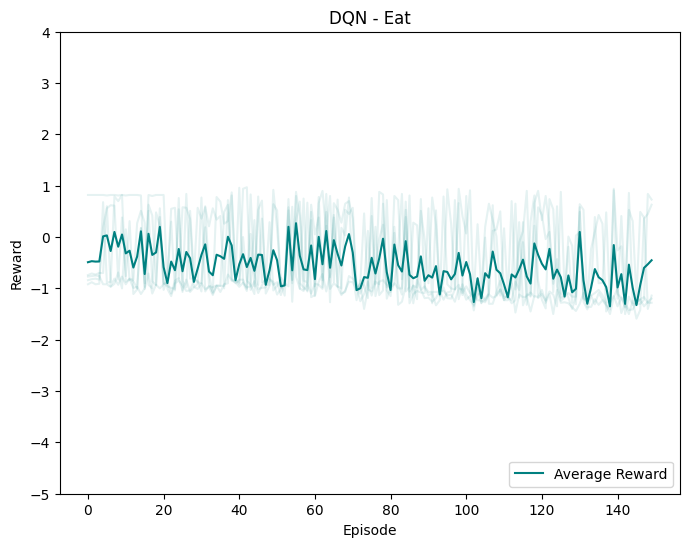

In [13]:
plot_results(env_name="Eat", scores=eat_scores, ylim =(-5,5), color = "teal")

## Quest Hard

In [14]:
# Create the environment with the observations keys required as input to the DQN
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP,
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY,
    )
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"], actions=NAVIGATE_ACTIONS)

# Train DQN on Quest Hard
quest_hard_scores = run_dqn(env,number_episodes=200,max_episode_length=250,iterations=5)

/usr/local/lib/python3.9/dist-packages/minihack/scripts/mh_patch_nhdat.sh: line 25: cd: too many arguments


876
episode reward: -1.2200000000000009
episode reward: -1.2300000000000009
episode reward: -1.2200000000000009
episode reward: -1.2200000000000009
episode reward: -1.2400000000000009
episode reward: -1.2400000000000009
episode reward: -1.0100000000000007
episode reward: -1.8200000000000014
episode reward: -1.5500000000000012
episode reward: -1.5400000000000011
episode reward: -2.5099999999999905
episode reward: -1.360000000000001
episode reward: -1.9100000000000015
episode reward: -1.6400000000000012
episode reward: -1.1500000000000008
episode reward: -0.5000000000000002
episode reward: -1.390000000000001
episode reward: -0.4200000000000002
episode reward: -2.3699999999999934
episode reward: -0.8100000000000005
episode reward: -1.1000000000000008
episode reward: -0.7500000000000004
episode reward: -1.7800000000000014
episode reward: -0.9900000000000007
episode reward: -0.5600000000000003
episode reward: -0.8400000000000005
episode reward: -1.9700000000000015
episode reward: -1.3900000

episode reward: -1.440000000000001
episode reward: -0.9100000000000006
episode reward: -8.229999999999869
episode reward: -3.7799999999999634
episode reward: -1.9200000000000015
episode reward: -1.400000000000001
episode reward: -2.629999999999988
episode reward: -1.490000000000001
episode reward: -2.0300000000000007
episode reward: -2.209999999999997
episode reward: -3.2999999999999736
episode reward: -1.5800000000000012
episode reward: -0.8500000000000005
episode reward: -0.9500000000000006
episode reward: -1.440000000000001
episode reward: -1.450000000000001
episode reward: -2.239999999999996
episode reward: -4.1699999999999555
episode reward: -3.889999999999961
episode reward: -0.6500000000000004
episode reward: -4.009999999999959
episode reward: -4.199999999999955
episode reward: -1.1900000000000008
episode reward: -1.1200000000000008
episode reward: -1.390000000000001
episode reward: -2.099999999999999
episode reward: -3.699999999999965
episode reward: -1.420000000000001
episode 

episode reward: -0.6300000000000003
episode reward: -2.4999999999999907
episode reward: -1.400000000000001
episode reward: -0.9700000000000006
episode reward: -0.36000000000000015
episode reward: -0.6900000000000004
episode reward: -1.0200000000000007
episode reward: -2.3699999999999934
episode reward: -2.239999999999996
episode reward: -6.379999999999908
episode reward: -3.2499999999999747
episode reward: -2.5199999999999902
episode reward: -2.399999999999993
episode reward: -4.009999999999959
episode reward: -2.389999999999993
episode reward: -1.0500000000000007
episode reward: -1.2400000000000009
episode reward: -2.2199999999999966
episode reward: -1.440000000000001
episode reward: -1.440000000000001
episode reward: -2.569999999999989
episode reward: -1.0000000000000007
episode reward: -0.6900000000000004
episode reward: -2.719999999999986
episode reward: -0.8100000000000005
episode reward: -3.2699999999999743
episode reward: -5.779999999999921
episode reward: -3.8799999999999613
ep

episode reward: -0.9700000000000006
episode reward: -0.9000000000000006
episode reward: -0.3200000000000001
episode reward: -5.429999999999929
episode reward: -0.9100000000000006
episode reward: -3.5499999999999683
episode reward: -9.069999999999851
episode reward: -2.809999999999984
episode reward: -0.8900000000000006
episode reward: -0.47000000000000025
episode reward: -5.699999999999923
episode reward: -9.08999999999985
episode reward: -1.8200000000000014
episode reward: -1.8900000000000015
episode reward: -0.9300000000000006
episode reward: -3.839999999999962
episode reward: -3.149999999999977
episode reward: -1.1700000000000008
episode reward: -2.709999999999986
episode reward: -0.7000000000000004
episode reward: -1.1400000000000008
episode reward: -4.379999999999951
episode reward: -2.569999999999989
episode reward: -2.9699999999999807
episode reward: -1.5200000000000011
episode reward: -2.8799999999999826
episode reward: -3.6799999999999655
episode reward: -1.7100000000000013
ep

episode reward: -2.06
episode reward: -3.8599999999999617
episode reward: -3.229999999999975
episode reward: -2.6999999999999864
episode reward: -4.339999999999952
episode reward: -9.199999999999848
episode reward: -2.07
episode reward: -2.010000000000001
episode reward: -4.049999999999958
episode reward: -1.2200000000000009
episode reward: -5.009999999999938
episode reward: -1.400000000000001
episode reward: -1.0600000000000007
episode reward: -1.5200000000000011
episode reward: -0.9300000000000006
episode reward: -6.639999999999903
episode reward: -1.1300000000000008
episode reward: -4.329999999999952
episode reward: -1.480000000000001
episode reward: -2.6099999999999883
episode reward: -9.349999999999845
episode reward: -5.239999999999933
episode reward: -4.329999999999952
episode reward: -6.29999999999991
episode reward: -2.6499999999999875
episode reward: -1.7700000000000014
episode reward: -6.999999999999895
episode reward: -3.139999999999977
episode reward: -1.6700000000000013
e

Plot results

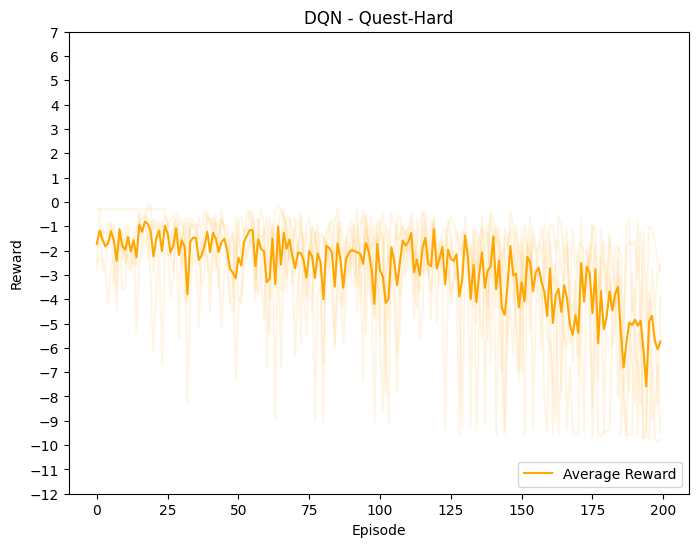

In [15]:
plot_results(env_name="Quest-Hard", scores=quest_hard_scores,ylim=(-12,8), color = "orange")